In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""This notebook creates the statistics of TAG in COUNTRY in YEAR"""

import inspect, os, sys

try :
    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

except :
    current_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile(inspect.currentframe()))[0]))
    folder_parts = current_folder.split(os.sep)
    pywikibot_folder = os.sep.join(folder_parts[:-1])

    if current_folder not in sys.path:
        sys.path.insert(0, current_folder)
    if pywikibot_folder not in sys.path:
        sys.path.insert(0, pywikibot_folder)

    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

import mwparserfromhell as mwh

In [2]:
from modules.wmtools import flickr_ripper, \
                            get_image_wikitext, \
                            get_project_name, \
                            get_registration_time, \
                            heat_color, \
                            upload_to_commons, \
                            upload_to_commons2, \
                            wrap_label

In [3]:
import pandas as pd
import numpy as np
from mako.template import Template
from io import StringIO
from datetime import datetime
from urllib.parse import urlencode
import requests
import json
from itertools import groupby
from operator import itemgetter
from functools import reduce
import math
import random

In [4]:
from geojson import Feature, Point, FeatureCollection
import geojson

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import pylab

sns.set_style("darkgrid")
#%matplotlib inline

In [6]:
# Project parameters
YEAR                = 2015
TAG                 = 'WLE'
TAG_EXT             = "Wiki Loves Earth"
COUNTRY             = "Spain"

BASE_NAME           = "Commons:Wiki Loves in {2}/{1}/{0}".format(YEAR, TAG_EXT, COUNTRY)
LOG_PAGE            = BASE_NAME + '/Log'
STATISTICS_PAGE     = BASE_NAME + '/Stats'
GALLERY_QI          = BASE_NAME + '/QI'
GALLERY_PAGE        = BASE_NAME + '/User Gallery'
MAP_WLE_PAGE        = BASE_NAME + '/Map'
BASE_SITE_DB_NAME   = "Commons:Wiki Loves in {1}/{0}".format(TAG_EXT, COUNTRY)
SITE_DB_PAGE        = BASE_SITE_DB_NAME + "/Sites DB"

VALID_NAMESPACES    = ['0', '4', '100', '102', '104'] # see https://es.wikipedia.org/wiki/Ayuda:Espacio_de_nombres
DAYS_BEFORE_REGISTRATION = 15

WLE_FINALIST_CATEGORY = {
    "2015": "Category:Finalists of {0} in {2} {1}".format(TAG_EXT, YEAR, COUNTRY),
    "2016": "Category:Evaluation of images from {0} {1} in {2} - Final".format(TAG_EXT, YEAR, COUNTRY),
    "2017": "Category:Evaluation of images from {0} {1} in {2} - Final".format(TAG_EXT, YEAR, COUNTRY)
}
commons_site = pb.Site('commons', 'commons')

In [7]:
# Base URL for interacting with MediaWiki API
MW_API_BASE_URL     = 'https://commons.wikimedia.org/w/api.php'
MW_API_QUERY_STRING = {"action": "query",
                       "format": "json",
                       "gulimit": "500",
                       "prop": "globalusage",
                       "guprop": "url|namespace",
                       "titles": None
                      }

In [8]:
# Different sizes for the images created
figsize=[15., 10.]
figsize_mid=[15., 15.]
figsize_half=[8., 10.]
figsize_high=[15., 30.]
figsize_low=[15., 6.]

In [9]:
# Folder management (templates, images...)
cwd = os.getcwd()

images_directory = os.path.join(cwd, 'images')
if not os.path.exists(images_directory):
    os.makedirs(images_directory)
    
templates_directory = os.path.join(cwd, 'templates')

In [10]:
now = (datetime.now().strftime("%Y-%m-%d"))

In [11]:
# Image description page
template_file = os.path.join(templates_directory, 'file.wiki')
fh = open(template_file, 'r', encoding = "utf-8")
image_wikitext = fh.read()
fh.close()

In [12]:
annexes = {
   'ES-AN': [u'Anexo:Lugares de importancia comunitaria de Andalucía', 'Andalusia'],
   'ES-AR': [u'Anexo:Lugares de importancia comunitaria de Aragón', 'Aragon'],
   'ES-AS': [u'Anexo:Lugares de importancia comunitaria de Asturias', 'Asturias'],
   'ES-CB': [u'Anexo:Lugares de importancia comunitaria de Cantabria', 'Cantabria'],
   'ES-CM': [u'Anexo:Lugares de importancia comunitaria de Castilla-La Mancha', 'Castile-La Mancha'],
   'ES-CL': [u'Anexo:Lugares de importancia comunitaria de Castilla y León', u'Castile and León'],
   'ES-CT': [u'Anexo:Lugares de importancia comunitaria de Cataluña', 'Catalonia'],
   'ES-MD': [u'Anexo:Lugares de importancia comunitaria de la Comunidad de Madrid', 'Community of Madrid'],
   'ES-VC': [u'Anexo:Lugares de importancia comunitaria de la Comunidad Valenciana', 'Valencian Community'],
   'ES-EX': [u'Anexo:Lugares de importancia comunitaria de Extremadura', 'Extremadura'],
   'ES-IB': [u'Anexo:Lugares de importancia comunitaria de las Islas Baleares', 'Balearic Islands'],
   'ES-CN': [u'Anexo:Lugares de importancia comunitaria de las Islas Canarias', 'Canary Islands'],
   'ES-GA': [u'Anexo:Lugares de importancia comunitaria de Galicia', 'Galicia'],
   'ES-RI': [u'Anexo:Lugares de importancia comunitaria de La Rioja', 'La Rioja'],
   'ES-NC': [u'Anexo:Lugares de importancia comunitaria de Navarra', 'Navarre'],
   'ES-MC': [u'Anexo:Lugares de importancia comunitaria de la Región de Murcia', 'Region of Murcia'],
   'ES-PV': [u'Anexo:Lugares de importancia comunitaria del País Vasco', 'Basque Country'],
   'ES-CE': [u'Anexo:Lugares de importancia comunitaria de Ceuta y Melilla', 'Ceuta'],
   'ES-ML': [u'Anexo:Lugares de importancia comunitaria de Ceuta y Melilla', 'Melilla'],
   'ES-MAGRAMA': [u'Anexo:Lugares de importancia comunitaria del MAGRAMA', 'MAGRAMA']
}

In [13]:
# Seaborn palette for autonomous communities
autcom_palette = [i[1:] for i in sns.color_palette('hls', 20).as_hex()]
autcoms = [annexes[key][1] for key in annexes]
autcom_colors = {autcom: autcom_palette[i] for i, autcom in enumerate(autcoms)}
autcom_colors

{'Andalusia': 'db5f57',
 'Aragon': 'db8657',
 'Asturias': 'dbae57',
 'Balearic Islands': '57d3db',
 'Basque Country': 'c957db',
 'Canary Islands': '57acdb',
 'Cantabria': 'dbd657',
 'Castile and León': '91db57',
 'Castile-La Mancha': 'b9db57',
 'Catalonia': '69db57',
 'Ceuta': 'db57c6',
 'Community of Madrid': '57db6c',
 'Extremadura': '57dbbb',
 'Galicia': '5784db',
 'La Rioja': '575cdb',
 'MAGRAMA': 'db5777',
 'Melilla': 'db579e',
 'Navarre': '7957db',
 'Region of Murcia': 'a157db',
 'Valencian Community': '57db94'}

## Auxiliary functions

In [14]:
def expand_itemid (_list):
    new_list = [{"itemid": i, 
                 "name": site_df[site_df['code'] == i]['name'].values[0], 
                 "category": site_df[site_df['code'] == i]['commons_cat'].values[0]}
                if type(site_df[site_df['code'] == i]['commons_cat'].values[0]) is str
                else {"itemid": i, 
                 "name": site_df[site_df['code'] == i]['name'].values[0], 
                 "category": ''}
                for i in _list]
    if len(new_list) > 0:
        new_list = sorted(new_list, key=lambda k: k['name']) 
    return new_list

def decode_list (_list) :
    try:
        new_list = _list[:]
    except :
        new_list = []
    return new_list

In [15]:
def to_geojson (row) :
    """For each site of community importance, identified by row['code'], this function
    creates a proper GeoJSON Feature"""
    images_subset_df = images_df[(images_df['code'] == row['code']) & (images_df['width'] > images_df['height'])]
    if len (images_subset_df.index) == 0:
        images_subset_df = images_df[images_df['code'] == row['code']]

    if len(images_subset_df[images_subset_df['qi'] == 'qi']) > 0 :
        popup_image = images_subset_df[images_subset_df['qi'] == 'qi'].sample(1, random_state=0)['image_title'].values[0]
    elif len(images_subset_df[images_subset_df['finalist'] == 'finalist']) > 0 :
        popup_image = images_subset_df[images_subset_df['finalist'] == 'finalist'].sample(1, random_state=0)['image_title'].values[0]
    else :
        popup_image = images_subset_df.sample(1, random_state=0)['image_title'].values[0]

    properties = {"description": "[[File:{0}|150px]]".format(popup_image),
                  "title": "[[:Category:Images of a site of community importance with code {0} from {2} {1} in {4}|{3}]]".format(row['code'], YEAR, TAG_EXT, row['name'], COUNTRY),
                  "marker-size": "small",
                  "marker-symbol": "circle",
                  "marker-color": autcom_colors[row['aut_com']]}

    feature = Feature(geometry=Point((float(row['longitude']), float(row['latitude']))), 
                      properties=properties
                     )
    return feature

## Retrieval of the sites of community importance

In [16]:
# retrieval of the WLE SCI (site of community importance) log
pb.output('Retrieving --> WLE site of community importance list')
site_list_page = pb.Page(commons_site, SITE_DB_PAGE)
site_list_text = StringIO(site_list_page.text[site_list_page.text.find('\n') + 
                                                      1:site_list_page.text.rfind('\n')])
site_df = pd.read_csv(site_list_text, sep=";",
                      index_col=False,
                      names=["name", "code", "magrama_url", "community",
                            "bio_region", "continent", "min_altitude",
                            "max_altitude", "avg_altitude", "longitude",
                            "latitude", "area", "marine_percentage",
                            "marine_area", "image", "commons_cat", "wikidata_id"])

pb.output('Retrieved --> WLE site of community importance list')

Retrieving --> WLE site of community importance list
Retrieved --> WLE site of community importance list


In [17]:
site_df["aut_com"] = site_df["community"].apply(lambda x: annexes[x][1])

In [18]:
site_df.head()

,name,code,magrama_url,community,bio_region,continent,min_altitude,max_altitude,avg_altitude,longitude,latitude,area,marine_percentage,marine_area,image,commons_cat,wikidata_id,aut_com
0,Sierra Alhamilla,ES0000045,ES0000045_tcm7-153353.pdf,ES-AN,Mediterránea,Europa,380.0,1380.0,921.0,-2.340899,36.996064,8383.76,0.0,0.0000,Sierra Alhamilla.jpg,Sierra Alhamilla,Q3483442,Andalusia
1,"Cabo de Gata, Nijar",ES0000046,ES0000046_tcm7-153354.pdf,ES-AN,Mediterránea,Europa,0.0,571.0,118.0,-2.095817,36.823929,49512.19,24.0,11882.9256,13 Cabo de Gata.JPG,Parque Natural de Cabo de Gata-Níjar,Q548667,Andalusia
2,Desierto de Tabernas,ES0000047,ES0000047_tcm7-153355.pdf,ES-AN,Mediteránea,Europa,180.0,1074.0,574.0,-2.505517,37.026100,11463.03,0.0,0.0000,Altiplano de Granada.jpg,Desert of Tabernas,Q939811,Andalusia
3,"Punta Entinas, Sabinar",ES0000048,ES0000048_tcm7-153356.pdf,ES-AN,Mediterránea,Europa,-6.0,48.0,5.0,-2.706500,36.689330,1944.75,0.0,0.0000,Charcón Reserva Punta Entinas.jpg,Paraje Natural Punta Entinas Sabinar,NaN,Andalusia
4,Albufera de Adra,ES6110001,ES6110001_tcm7-154410.pdf,ES-AN,Mediterránea,Europa,-5.0,20.0,9.0,-2.952299,36.752934,135.27,0.0,0.0000,NaN,NaN,NaN,Andalusia


In [19]:
site_length = len(site_df.index)
site_length

1449

In [20]:
valid_sites = site_df['code'].values
valid_sites

array(['ES0000045', 'ES0000046', 'ES0000047', ..., 'ES7020126',
       'ES7020128', 'ES90ATL01'], dtype=object)

## Retrieval of the images log

In [21]:
pb.output('Retrieving --> {1} {0} in {2} images list from cache'.format(YEAR, TAG, COUNTRY))
list_page = pb.Page(commons_site, LOG_PAGE)
list_page_text = StringIO(list_page.text[list_page.text.find('\n') + 1:list_page.text.rfind('\n')])
images_df = pd.read_csv(list_page_text,
                            sep=";",
                            index_col=False,
                            names=['image_title', 'code', 
                               'uploader', 'uploader_registration', 
                               'timestamp', 'date', 'size', 
                               'height', 'width', 'qi', 
                               'finalist']
                       ).fillna('')
pb.output('Retrieved --> {1} {0} in {2} images list from cache'.format(YEAR, TAG, COUNTRY))

images_df['timestamp'] = pd.to_datetime(images_df['timestamp'], format="%Y-%m-%d %H:%M:%S")
images_df['days_from_user_reg'] = images_df.apply(lambda row: (row['timestamp'] - pd.to_datetime(row['uploader_registration'], format="%Y-%m-%d")).days, axis=1)
images_df['days_from_creation'] = images_df.apply(lambda row: (row['timestamp'] - pd.to_datetime(row['date'], format="%Y-%m-%d")).days, axis=1)

images_df.set_index(["timestamp"], inplace=True)
del images_df.index.name

total_images_length = len(images_df)
total_images_length

Retrieving --> WLE 2015 in Spain images list from cache
Retrieved --> WLE 2015 in Spain images list from cache


5013

In [22]:
images_df.head()

,image_title,code,uploader,uploader_registration,date,size,height,width,qi,finalist,days_from_user_reg,days_from_creation
2015-05-03 12:36:37,"""Encina andante"". Parque Natural de la Subbéti...",ES6130002,Teckömo,2015-05-03,2011-05-09,3801106,2592,3456,,,0,1455.0
2015-05-09 12:54:58,'Grasilla' (Pinguicula grandiflora) en la Send...,ES1200001,ROSUROB,2015-05-09,2007-05-16,1593022,1932,2576,,,0,2915.0
2015-05-13 18:00:59,(1) ABEJA LIBANDO FLOR DEL NARANJO EN EL CORRA...,ES4320037,JESUS SANCHEZ RODRIGUEZ,2015-05-13,2009-05-03,984666,3072,2304,,,0,2201.0
2015-05-13 18:01:00,(2) ABEJA LIBANDO FLOR DEL NARANJO EN EL CORRA...,ES4320037,JESUS SANCHEZ RODRIGUEZ,2015-05-13,2009-05-03,1147630,2304,3072,,,0,2201.0
2015-05-06 19:25:36,0004395970-original.jpg,ES7010033,Tamara k,2009-12-13,2013-03-02,3672007,2092,3000,,,1970,795.0


### Quality images

In [23]:
qi_list = images_df[images_df['qi'] == 'qi']['image_title']
qi_list

2015-05-09 21:17:15    Bardenas Reales, Navarra, España, 2015-01-06, ...
2015-05-09 21:17:12    Bardenas Reales, Navarra, España, 2015-01-06, ...
2015-05-09 21:17:12    Bardenas Reales, Navarra, España, 2015-01-06, ...
2015-05-01 14:48:02    Barranco del Monte, Linás de Broto, Huesca, Es...
2015-05-01 14:48:02    Barranco del Monte, Linás de Broto, Huesca, Es...
2015-05-03 17:19:02    Camino a la ermita de la Virgen de la Peña, LI...
2015-05-31 23:30:40    Carnota - Monte Pindo (A Coruña, Galicia, Espa...
2015-05-01 20:04:45        Cercanías de la estación del Alto Campoo..jpg
2015-05-01 12:20:08    El Grau Vell, Puerto de Sagunto, España, 2015-...
2015-05-01 12:20:11    El Grau Vell, Puerto de Sagunto, España, 2015-...
2015-05-01 12:20:15    El Grau Vell, Puerto de Sagunto, España, 2015-...
2015-05-01 12:20:08    El Grau Vell, Puerto de Sagunto, España, 2015-...
2015-05-01 12:20:13    El Grau Vell, Puerto de Sagunto, España, 2015-...
2015-05-01 12:20:18    El Grau Vell, Puerto de Sagu

In [24]:
qi_length = len(qi_list)
qi_length

56

## Uploaders

### Uploaders age

In [25]:
uploaders = images_df.groupby(['uploader']).min()['days_from_user_reg']
uploaders

uploader
15Gitte                                                                              0
1Dalanyo                                                                             0
ACaminero                                                                         3084
ALFONSO GONZALEZ RODENAS                                                             0
ALISIAHERNANDEZ89                                                                    0
ALusitana                                                                           14
Aaroncm95                                                                            0
Abel Muñoz                                                                           0
Acuencam                                                                             7
Adolfobrigido                                                                      865
Adrianrodriguezfotografia                                                            0
Aechav                            

In [26]:
authors_length = len(uploaders.index)
authors_length

396

In [27]:
days_from_user_reg = uploaders[~uploaders.index.str.contains('flickr')].value_counts().sort_index(ascending=False)
days_from_user_reg

3436      1
3427      1
3425      1
3413      1
3356      1
3234      1
3116      1
3087      1
3084      1
2949      2
2925      1
2802      1
2749      1
2649      1
2633      1
2624      1
2568      1
2373      1
2317      1
2295      1
2285      1
2229      1
2184      1
2148      1
1993      1
1968      1
1899      1
1823      1
1778      1
1767      1
       ... 
426       1
413       1
389       1
382       1
356       1
316       1
273       1
265       2
257       1
248       1
242       1
240       1
189       1
128       1
97        1
36        1
16        3
15        1
14        1
13        3
11        2
10        2
8         1
7         2
5         1
4         1
3         4
2         6
1        38
0       234
Name: days_from_user_reg, Length: 93, dtype: int64

In [28]:
age = pd.cut(uploaders, bins=[0, 15, 365, 730, 3650, 5000], include_lowest=True).value_counts()

[[commons:File:WLE 2015 in Spain - Contestant age.png]]
Already in commons


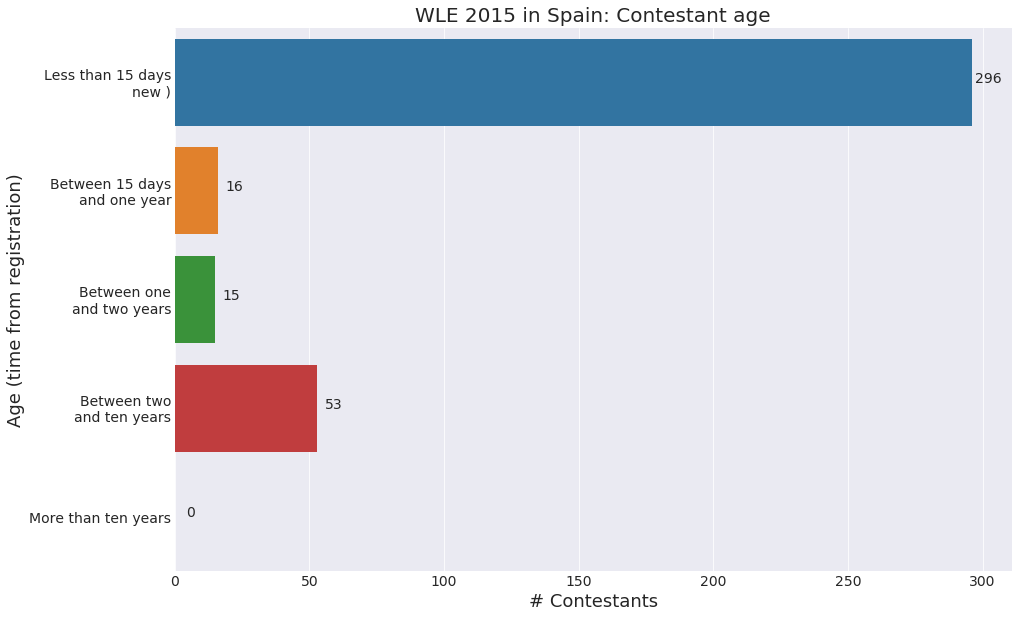

In [29]:
padding = {
    "2017": 3,
    "2016": 3,
    "2015": 6
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=age.index, x=age.values)
p.set_xlabel("# Contestants", fontsize=18)
p.set_ylabel("Age (time from registration)", fontsize=18)

p.set_title(label='{1} {0} in {2}: Contestant age'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

p.set_yticklabels(['Less than 15 days\nnew )', 
                   'Between 15 days\nand one year', 
                   'Between one\nand two years', 
                   'Between two\nand ten years', 
                   'More than ten years'])

for patch in ax.patches:
    ax.text(patch.get_width() + PADDING,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

desc = get_image_wikitext(image_wikitext,
                          '{1} {0} in {2}: Contestant age. Time from registration to first contribution to contest.'.format(YEAR, TAG_EXT, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Contestant age.png".format(YEAR, TAG, COUNTRY), desc)

### New uploaders

In [30]:
new_uploaders = uploaders[uploaders<DAYS_BEFORE_REGISTRATION].index
new_uploaders

Index(['15Gitte', '1Dalanyo', 'ALFONSO GONZALEZ RODENAS', 'ALISIAHERNANDEZ89',
       'ALusitana', 'Aaroncm95', 'Abel Muñoz', 'Acuencam',
       'Adrianrodriguezfotografia', 'Aechav',
       ...
       'Webposible', 'Whistletraveler', 'Wux1989', 'Xavier GF', 'Xoxemorente',
       'Yolandaeb', 'Yonathan Tabaibo', 'Yoseph Walker', 'Zangolotina',
       'Zeus11 Commons'],
      dtype='object', name='uploader', length=295)

In [31]:
new_uploaders_length = len(new_uploaders)
new_uploaders_length

295

### Images by uploader

In [32]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader = images_per_uploader.iloc[np.lexsort([images_per_uploader.index, -images_per_uploader.values])]
images_per_uploader

https://www.flickr.com/people/10352740@N03 Turol Jones, un artista de cojones    594
Tanja 007                                                                        244
Millars                                                                          209
ACaminero                                                                        113
Francisco Lera                                                                   112
Bhavagati                                                                        101
Mabelcalabuig                                                                     96
MsLids                                                                            92
Baldomorejon                                                                      87
https://www.flickr.com/people/48600102544@N01 Victor R. Ruiz                      86
Aglaya72                                                                          75
Mr.Wagner22                                                      

In [33]:
new_uploaders_contributions = images_per_uploader[new_uploaders]
new_uploaders_contributions

uploader
15Gitte                       35
1Dalanyo                       9
ALFONSO GONZALEZ RODENAS       4
ALISIAHERNANDEZ89              1
ALusitana                     40
Aaroncm95                      3
Abel Muñoz                     7
Acuencam                       9
Adrianrodriguezfotografia      6
Aechav                         1
Agila13                       32
Agustin de Sanluca             3
Ahmed Mehrem                   1
Alejandro MezcuA              39
Alfoncarrillo                  1
Alfredo Serra                  2
Aliciamartincaballero          3
Allona Riera                   1
Alzur000                      12
Amanda Hiems                   1
Ameliacsj                      4
Ameljim                        2
Amosya                         6
Anaarias                       5
Anajg2                         3
Andrés Flajszer               52
Angel camu                     5
Anthiro 57                    50
Anubisvive                     9
AnuskaCM                      18
 

In [34]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
top_uploaders ={
    "2017": 16,
    "2016": 18,
    "2015": 19
}
TOP_UPLOADERS = top_uploaders[str(YEAR)]

In [35]:
remaining_images_per_uploader = images_per_uploader[:TOP_UPLOADERS]
remaining_images_per_uploader.index = remaining_images_per_uploader.index.map(flickr_ripper).map(lambda x: wrap_label(x, 16))
remaining_images_per_uploader

Turol Jones, un\nartista de\ncojones (flickr)    594
Tanja 007                                        244
Millars                                          209
ACaminero                                        113
Francisco Lera                                   112
Bhavagati                                        101
Mabelcalabuig                                     96
MsLids                                            92
Baldomorejon                                      87
Victor R. Ruiz\n(flickr)                          86
Aglaya72                                          75
Mr.Wagner22                                       69
Raúl Hidalgo\n(flickr)                            68
Boruguita                                         54
Javier martinlo                                   54
Andrés Flajszer                                   52
Namiac                                            52
Anthiro 57                                        50
Okenok                                        

[[commons:File:WLE 2015 in Spain - Top authors.png]]
Already in commons


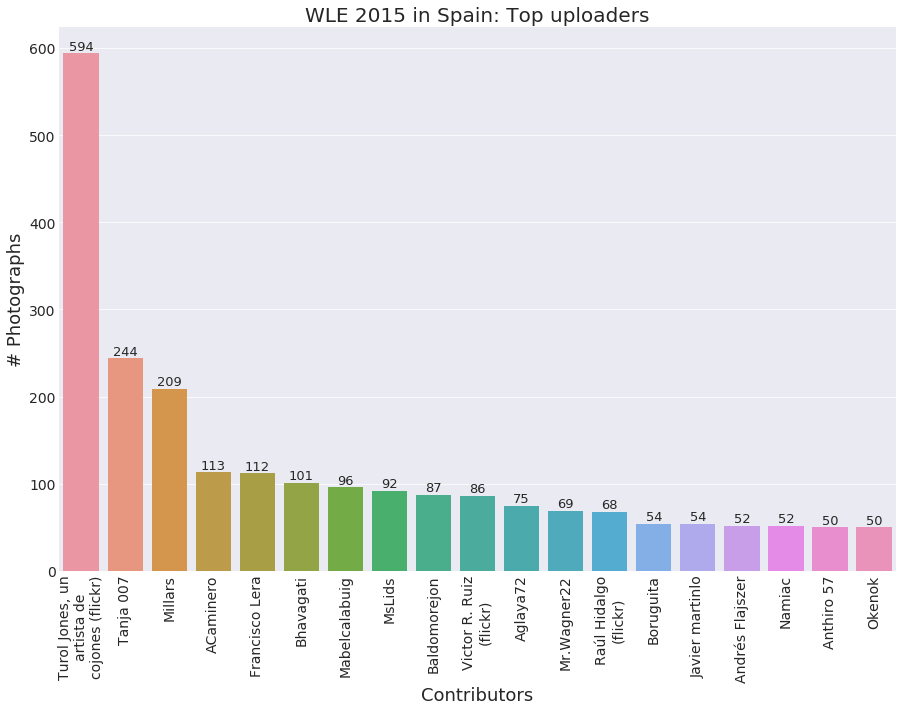

In [36]:
padding = {
    "2017": 2,
    "2016": 3,
    "2015": 4
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_per_uploader.index, y=remaining_images_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in {2}: Top uploaders'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + PADDING,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

desc = get_image_wikitext(image_wikitext,
                          'Top {2} contributors to {1} {0} in {3}'.format(YEAR, TAG_EXT, TOP_UPLOADERS, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Top authors.png".format(YEAR, TAG, COUNTRY), desc)

In [37]:
images_df['uploader'].unique()

array(['Teckömo', 'ROSUROB', 'JESUS SANCHEZ RODRIGUEZ', 'Tamara k',
       'Maria planas aulet', 'Jesusccastillo',
       'https://www.flickr.com/people/10352740@N03 Turol Jones, un artista de cojones',
       'Olga lesiv', 'Jmgarciadguez',
       'https://www.flickr.com/people/78391947@N06 Antonio L', 'Evirio',
       'Aechav', 'Cadiz-Turismo', 'Javierme', 'ALusitana',
       'https://www.flickr.com/people/100761407@N02 Daniel Garcia-Castellanos',
       'Arment mad', 'Luis Martinez Villar',
       'https://www.flickr.com/people/63438723@N03 sergioski1982',
       'Jflaquer', 'Bhavagati',
       'https://www.flickr.com/people/48600102544@N01 Victor R. Ruiz',
       'Gwaihhir', 'Colin C Wheeler', 'Walkinaway', 'Polmatce',
       'Boruguita', 'Dasanun', 'Tuispi', 'Rahernaiz 91', 'Leviatan189',
       'Mr.Wagner22', 'Tanja 007', 'Pcaldenteypozo', 'Fsanchezme',
       'Ilcantabria', 'Kuock', 'Fom45', 'Mentefria88', 'Javier martinlo',
       'Mabelcalabuig', 'Freddymalde', 'Priast80',
    

In [38]:
valid_images_length = len(images_df[images_df['code'].isin(valid_sites)].index)
valid_images_length

4669

In [39]:
images_df[images_df['code'].isin(valid_sites)]['code'].unique()

array(['ES6130002', 'ES1200001', 'ES4320037', 'ES7010033', 'ES5110001',
       'ES0000072', 'ES0000019', 'ES2420039', 'ES4230014', 'ES0000147',
       'ES4320071', 'ES4250010', 'ES7020054', 'ES2410014', 'ES7020043',
       'ES5120016', 'ES2410017', 'ES3110005', 'ES0000049', 'ES2130004',
       'ES2130003', 'ES1200008', 'ES0000054', 'ES4130003', 'ES0000016',
       'ES2410010', 'ES2410023', 'ES0000013', 'ES1110003', 'ES0000149',
       'ES2130005', 'ES7020044', 'ES0000001', 'ES0000047', 'ES6200035',
       'ES4140082', 'ES0000024', 'ES4160109', 'ES7010023', 'ES7020096',
       'ES5213021', 'ES6170002', 'ES1120005', 'ES6150002', 'ES3110001',
       'ES4170083', 'ES6160007', 'ES6170003', 'ES0000090', 'ES6200010',
       'ES0000337', 'ES0000146', 'ES0000020', 'ES2410006', 'ES2410154',
       'ES4320038', 'ES6170029', 'ES2410003', 'ES5310005', 'ES5110025',
       'ES0000022', 'ES2410054', 'ES5140006', 'ES4310010', 'ES0000046',
       'ES2430096', 'ES0000023', 'ES6140009', 'ES6310001', 'ES11

### Sites by uploader

In [40]:
sites_per_uploader_df = images_df[images_df['code'].isin(valid_sites)].\
                                    groupby(['uploader']).\
                                    agg({"code": pd.Series.nunique}).\
                                    sort_values('code', ascending=False)
sites_per_uploader = sites_per_uploader_df["code"]
sites_per_uploader = sites_per_uploader.rename('sites')
sites_per_uploader = sites_per_uploader.iloc[np.lexsort([sites_per_uploader.index, -sites_per_uploader.values])]
sites_per_uploader

uploader
Aglaya72                                                                         70
Tanja 007                                                                        31
Baldomorejon                                                                     29
https://www.flickr.com/people/48600102544@N01 Victor R. Ruiz                     23
Polmatce                                                                         18
https://www.flickr.com/people/10352740@N03 Turol Jones, un artista de cojones    17
Boruguita                                                                        13
Kadellar                                                                         13
MsLids                                                                           13
Echeyde777                                                                       12
Tuispi                                                                           12
AnuskaCM                                                           

In [41]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
top_uploaders_by_site ={
    "2017": 16,
    "2016": 16,
    "2015": 16
}
TOP_UPLOADERS_BY_SITE = top_uploaders_by_site[str(YEAR)]

In [42]:
wle_sites_length = images_df[images_df['code'].isin(valid_sites)]['code'].unique().size
wle_sites_length

473

[[commons:File:WLE 2015 in Spain - Top authors by site of community importance.png]]
Already in commons


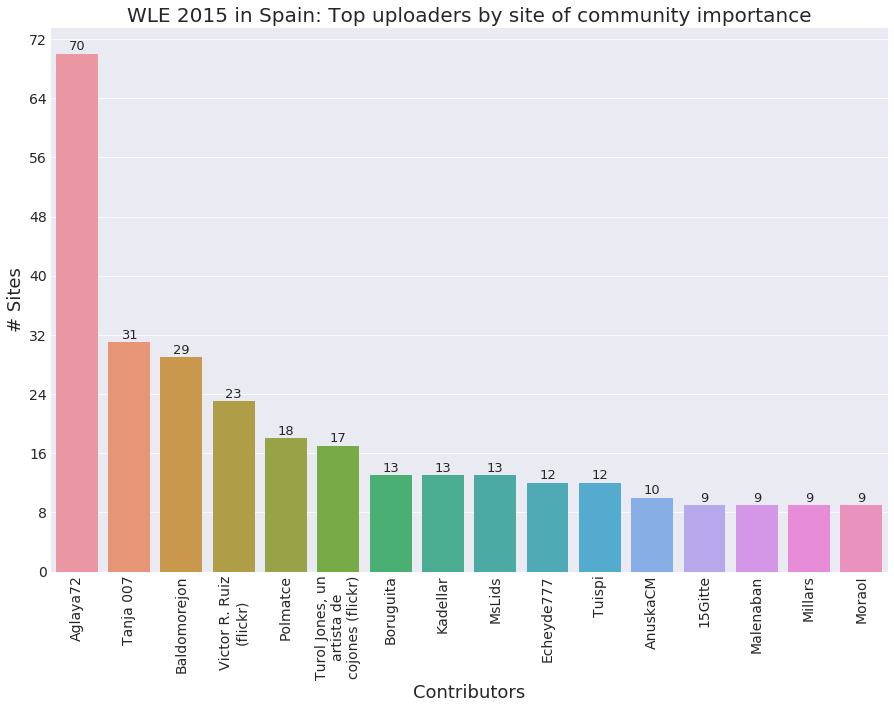

In [43]:
padding = {
    "2017": 0.5,
    "2016": 0.5,
    "2015": 0.5
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=sites_per_uploader[:TOP_UPLOADERS_BY_SITE].index.map(flickr_ripper).map(lambda x: wrap_label(x, 16)), 
                y=sites_per_uploader[:TOP_UPLOADERS_BY_SITE].values
               )
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Sites", fontsize=18)

p.set_title(label='{1} {0} in {2}: Top uploaders by site of community importance'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.yaxis.set_major_locator(MaxNLocator(integer=True))

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + PADDING,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

desc = get_image_wikitext(image_wikitext,
                          'Top {2} contributors to {1} {0} in {3}'.format(YEAR, TAG_EXT, TOP_UPLOADERS_BY_SITE, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Top authors by site of community importance.png".format(YEAR, TAG, COUNTRY), desc)

In [44]:
uploaders_df = pd.concat([sites_per_uploader, images_per_uploader], axis=1).fillna(0)
uploaders_df.columns=['Sites', 'Photographs']
uploaders_df['Sites'] = uploaders_df['Sites'].astype(int)
uploaders_df = uploaders_df.iloc[np.lexsort([uploaders_df.index, -uploaders_df['Photographs']])]
uploaders_df.index = uploaders_df.index.map(flickr_ripper).map(lambda x: wrap_label(x, 16))
uploaders_df

,Sites,Photographs
"Turol Jones, un\nartista de\ncojones (flickr)",17,594
Tanja 007,31,244
Millars,9,209
ACaminero,5,113
Francisco Lera,6,112
Bhavagati,7,101
Mabelcalabuig,6,96
MsLids,13,92
Baldomorejon,29,87
Victor R. Ruiz\n(flickr),23,86


[[commons:File:WLE 2015 in Spain - Top authors (2).png]]
Already in commons


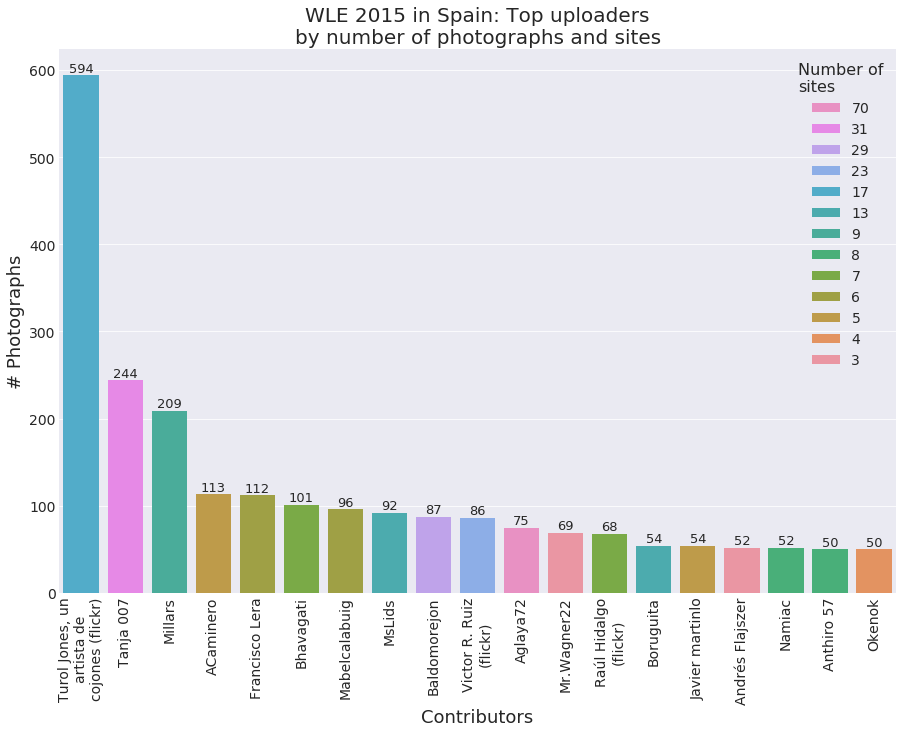

In [45]:
padding = {
    "2017": 2,
    "2016": 3,
    "2015": 4
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=uploaders_df[:TOP_UPLOADERS].index, 
                y=uploaders_df[:TOP_UPLOADERS]['Photographs'], 
                hue=uploaders_df[:TOP_UPLOADERS]['Sites'],
                dodge=False)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in {2}: Top uploaders\nby number of photographs and sites'.format(YEAR, TAG, COUNTRY), fontsize=20)

p.tick_params(labelsize=14)
p.set_xticklabels(p.get_xticklabels(), rotation=90)

handles, labels = p.get_legend_handles_labels()
handles.reverse()
labels.reverse()

legend = plt.legend(loc='upper right', 
                    title='Number of\nsites', 
                    fontsize=14,
                    labels=labels,
                    handles=handles)
plt.setp(legend.get_title(), fontsize=16)

for patch in p.patches:
    height = patch.get_height()
    if not math.isnan(height):
        p.text(patch.get_x() + patch.get_width()/2.,
                height + PADDING,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

desc = get_image_wikitext(image_wikitext,
                          'Top {2} contributors to {1} {0} in {3} with contribution to sites'.format(YEAR, TAG_EXT, TOP_UPLOADERS, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Top authors (2).png".format(YEAR, TAG, COUNTRY), desc)

## Contributions by day

In [46]:
upload_ts = images_df['image_title'].resample('d').count()
try:
    upload_ts[datetime(YEAR, 5, 31)] = upload_ts[datetime(YEAR, 5, 31)] + upload_ts[datetime(YEAR, 6, 1)]
    upload_ts.drop(datetime(YEAR, 6, 1), inplace=True)
except :
    pass
upload_ts = pd.Series([0]*31, index = pd.date_range(datetime(YEAR, 5, 1), periods=31, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

2015-05-01    128
2015-05-02    122
2015-05-03    111
2015-05-04    106
2015-05-05    107
2015-05-06     67
2015-05-07    135
2015-05-08     31
2015-05-09     79
2015-05-10     77
2015-05-11     78
2015-05-12    155
2015-05-13     38
2015-05-14     84
2015-05-15     33
2015-05-16     50
2015-05-17    100
2015-05-18    167
2015-05-19     90
2015-05-20    140
2015-05-21    242
2015-05-22     95
2015-05-23     66
2015-05-24    126
2015-05-25     73
2015-05-26    791
2015-05-27    217
2015-05-28    159
2015-05-29    194
2015-05-30    307
2015-05-31    845
Freq: D, dtype: int64

[[commons:File:WLE 2015 in Spain - Uploads by day.png]]
Already in commons


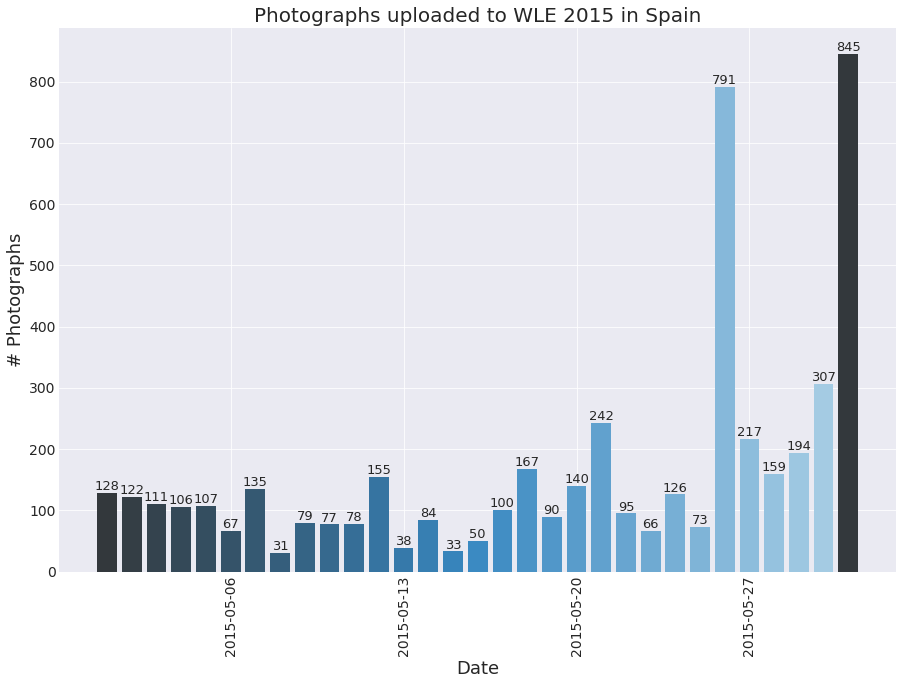

In [47]:
padding = {
    "2017": 4,
    "2016": 4,
    "2015": 5
}
PADDING = padding[str(YEAR)]

# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 30))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in {2}'.format(YEAR, TAG, COUNTRY), fontsize=20)

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + PADDING,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

desc = get_image_wikitext(image_wikitext,
                          'Number of images uploaded to {1} {0} in {2} by day'.format(YEAR, TAG, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(plt, "{1} {0} in {2} - Uploads by day.png".format(YEAR, TAG, COUNTRY), desc)

## MediaWiki tables creation

In [48]:
# Dataframe merge (images and sites)
images_extended_df = pd.merge(images_df, site_df, on='code', how='left')
len(images_extended_df.index)

5013

### New uploaders

In [49]:
new_uploaders_contributions = images_per_uploader[new_uploaders]
new_uploaders_contributions

uploader
15Gitte                       35
1Dalanyo                       9
ALFONSO GONZALEZ RODENAS       4
ALISIAHERNANDEZ89              1
ALusitana                     40
Aaroncm95                      3
Abel Muñoz                     7
Acuencam                       9
Adrianrodriguezfotografia      6
Aechav                         1
Agila13                       32
Agustin de Sanluca             3
Ahmed Mehrem                   1
Alejandro MezcuA              39
Alfoncarrillo                  1
Alfredo Serra                  2
Aliciamartincaballero          3
Allona Riera                   1
Alzur000                      12
Amanda Hiems                   1
Ameliacsj                      4
Ameljim                        2
Amosya                         6
Anaarias                       5
Anajg2                         3
Andrés Flajszer               52
Angel camu                     5
Anthiro 57                    50
Anubisvive                     9
AnuskaCM                      18
 

### Authors dataframe

In [50]:
valid_images_per_uploader = images_df[images_df['code'].isin(valid_sites)]['uploader'].value_counts()
valid_images_per_uploader = valid_images_per_uploader.rename('valid_images')
valid_images_per_uploader = valid_images_per_uploader.iloc[np.lexsort([valid_images_per_uploader.index, -valid_images_per_uploader.values])]
valid_images_per_uploader

https://www.flickr.com/people/10352740@N03 Turol Jones, un artista de cojones    577
Tanja 007                                                                        243
Millars                                                                          208
ACaminero                                                                        112
Francisco Lera                                                                   110
Bhavagati                                                                        100
MsLids                                                                            90
Mabelcalabuig                                                                     86
Baldomorejon                                                                      85
https://www.flickr.com/people/48600102544@N01 Victor R. Ruiz                      80
Aglaya72                                                                          74
https://www.flickr.com/people/47153649@N03 Raúl Hidalgo          

In [51]:
site_list_per_uploader = images_extended_df[images_extended_df['code'].isin(valid_sites)]\
                                                                      .groupby('uploader')['code']\
                                                                      .apply(set)\
                                                                      .apply(lambda x: filter(None, x))\
                                                                      .apply(lambda x: expand_itemid(x))\
                                                                      .rename('site_list', inplace=True)
site_list_per_uploader

uploader
15Gitte                                                                           [{'itemid': 'ES0000033', 'name': 'Laguna de Fu...
1Dalanyo                                                                          [{'itemid': 'ES2110011', 'name': 'Zadorraren s...
ACaminero                                                                         [{'itemid': 'ES3110002', 'name': 'Cuenca del r...
ALFONSO GONZALEZ RODENAS                                                          [{'itemid': 'ES0000016', 'name': 'Ordesa y Mon...
ALISIAHERNANDEZ89                                                                 [{'itemid': 'ES6200002', 'name': 'Carrascoy y ...
ALusitana                                                                         [{'itemid': 'ES4130003', 'name': 'Picos de Eur...
Aaroncm95                                                                         [{'itemid': 'ES0000024', 'name': 'Doñana', 'ca...
Abel Muñoz                                                         

In [52]:
authors_df = pd.concat([images_per_uploader, valid_images_per_uploader, sites_per_uploader, site_list_per_uploader], axis=1)\
               .sort_values(by='images', ascending=False)\
               .reset_index()\
               .rename(columns = {'index': 'contestant'})

authors_df[['images', 'valid_images', 'sites']] = authors_df[['images', 'valid_images', 'sites']]\
                                                                        .fillna(0)\
                                                                        .astype('int')

authors_df = authors_df.iloc[np.lexsort([authors_df['contestant'], -authors_df['images']])]
authors_df['registration_string'] = authors_df['contestant'].map(lambda x: get_registration_time(x))
authors_df['site_list'] = authors_df['site_list'].map(lambda x: decode_list(x))
authors_df

,contestant,images,valid_images,sites,site_list,registration_string
0,https://www.flickr.com/people/10352740@N03 Tur...,594,577,17,"[{'itemid': 'ES2410006', 'name': 'Bujaruelo - ...",
1,Tanja 007,244,243,31,"[{'itemid': 'ES1120004', 'name': 'A Marronda',...",2015-05-28
2,Millars,209,208,9,"[{'itemid': 'ES2410006', 'name': 'Bujaruelo - ...",2007-04-04
3,ACaminero,113,112,5,"[{'itemid': 'ES3110002', 'name': 'Cuenca del r...",2006-12-05
4,Francisco Lera,112,110,6,"[{'itemid': 'ES2410052', 'name': 'Alto Valle d...",2015-05-20
5,Bhavagati,101,100,7,"[{'itemid': 'ES0000022', 'name': 'Aigüestortes...",2015-05-21
6,Mabelcalabuig,96,86,6,"[{'itemid': 'ES6200031', 'name': 'Cabo Cope', ...",2015-05-16
7,MsLids,92,90,13,"[{'itemid': 'ES0000240', 'name': 'Costa Sud de...",2015-05-26
8,Baldomorejon,87,85,29,"[{'itemid': 'ES0000140', 'name': 'Bahía de Cád...",2015-05-18
9,https://www.flickr.com/people/48600102544@N01 ...,86,80,23,"[{'itemid': 'ES7010049', 'name': 'Arinaga', 'c...",


### Images by site dataframe

In [53]:
images_per_site = images_extended_df[images_extended_df['code'].isin(valid_sites)]['code'].value_counts()
images_per_site

ES0000016    279
ES2410003    127
ES2420039    105
ES4230014     78
ES1200001     71
ES2410017     70
ES0000149     69
ES3110004     68
ES0000046     66
ES3110002     63
ES0000115     61
ES0000013     59
ES6170002     56
ES7020043     55
ES7020045     55
ES0000035     53
ES0000022     51
ES2410040     45
ES6200002     43
ES0000147     43
ES2410006     42
ES6170003     40
ES0000003     39
ES6200010     38
ES5310005     36
ES4160109     34
ES0000049     34
ES4130010     34
ES1200008     33
ES5120016     33
            ... 
ES0000125      1
ES7020041      1
ES7010018      1
ES7010024      1
ES1200016      1
ES1200030      1
ES7020011      1
ES5310031      1
ES1300004      1
ES4320011      1
ES0000045      1
ES5223055      1
ES1120006      1
ES4310008      1
ES7011003      1
ES6160006      1
ES5130004      1
ES4240003      1
ES1300013      1
ES1200056      1
ES4320031      1
ES5213024      1
ES4310004      1
ES4150085      1
ES5213033      1
ES0000169      1
ES0000317      1
ES7010002     

In [54]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of sites with more than X pictures
top_sites ={
    "2017": 20,
    "2016": 22,
    "2015": 18
}
TOP_SITES = top_sites[str(YEAR)]

In [55]:
images_per_site_df = pd.DataFrame(data=images_per_site).reset_index()
images_per_site_df.rename(columns={'index': 'code', 'code': 'count'}, inplace=True)

In [56]:
images_per_site_df = pd.merge(images_per_site_df, site_df, on='code')[['count', 'code', 'name', 'aut_com', 'latitude', 'longitude', 'commons_cat']].fillna('')
images_per_site_df = images_per_site_df.iloc[np.lexsort([images_per_site_df['name'], -images_per_site_df['count']])]
images_per_site_df['name'] = images_per_site_df['name'].map(lambda x: x.replace('_', ' '))
images_per_site_df.head()

,count,code,name,aut_com,latitude,longitude,commons_cat
0,279,ES0000016,Ordesa y Monte Perdido,Aragon,42.640000,-0.031900,Parque Nacional de Ordesa y Monte Perdido
1,127,ES2410003,Los Valles,Aragon,42.810000,-0.680000,Los Valles Occidentales Natural Park
2,105,ES2420039,Rodeno de Albarracín,Aragon,40.370278,-1.386667,Pinares de Rodeno
3,78,ES4230014,Serranía de Cuenca,Castile-La Mancha,40.292222,-1.954444,Serranía de Cuenca
4,71,ES1200001,Picos de Europa (Asturias),Asturias,43.242800,-4.913300,Picos de Europa


In [57]:
compact_images_per_site = images_per_site_df[:TOP_SITES][['count', 'name']]
compact_images_per_site = compact_images_per_site.iloc[np.lexsort([compact_images_per_site['name'], -compact_images_per_site['count']])]
compact_images_per_site['name'] = compact_images_per_site['name'].map(lambda x: wrap_label(x, 25))
compact_images_per_site

,count,name
0,279,Ordesa y Monte Perdido
1,127,Los Valles
2,105,Rodeno de Albarracín
3,78,Serranía de Cuenca
4,71,Picos de Europa\n(Asturias)
5,70,Río Aragón (Jaca)
6,69,Posets - Maladeta
7,68,Cuenca del río Manzanares
8,66,"Cabo de Gata, Nijar"
9,63,Cuenca del río Lozoya y\nSierra Norte


[[commons:File:WLE 2015 in Spain - Top sites of community importance.png]]
Already in commons


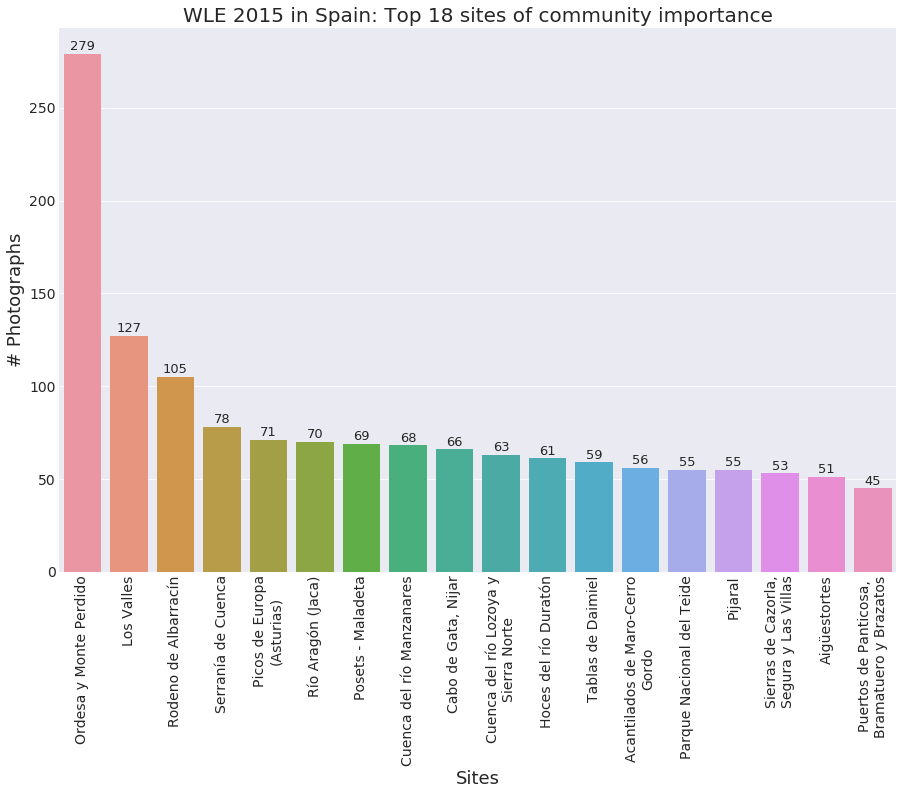

In [58]:
padding = {
    "2017": 0.5,
    "2016": 2,
    "2015": 2
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=compact_images_per_site, x='name', y='count')
p.set_xlabel("Sites", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in {3}: Top {2} sites of community importance'.format(YEAR, TAG, TOP_SITES, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + PADDING,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

desc = get_image_wikitext(image_wikitext,
                          'Top {2} sites of community importance in {1} {0} in {3}'.format(YEAR, TAG_EXT, TOP_SITES, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Top sites of community importance.png".format(YEAR, TAG, COUNTRY), desc)

## Map creation

In [59]:
images_per_site_df['geojson'] = images_per_site_df.apply(lambda row: to_geojson(row), axis=1)

In [60]:
features = images_per_site_df['geojson'].tolist()
feature_collection = FeatureCollection(features)
dump = geojson.dumps(feature_collection, ensure_ascii=False, indent=2)
#print(dump)

In [61]:
map_template = """<mapframe text="Sites of community importance" latitude="39" longitude="-4" zoom="5" width="800" height="600" align="center"> 
${map}
</mapframe>"""
vars = {
    "map": dump
}
t = Template(map_template)
map_text = t.render(**vars)

In [62]:
maps_page = pb.Page(commons_site, MAP_WLE_PAGE)
if maps_page.text.strip() != map_text.strip() :
    maps_page.text = map_text
    pb.output('Publishing --> {0} in {1} map'.format(TAG, COUNTRY))
    maps_page.save('{0} in {1} map'.format(TAG, COUNTRY))

Publishing --> WLE in Spain map
Page [[commons:Commons:Wiki Loves in Spain/Wiki Loves Earth/2015/Map]] saved


## Autonomous communities

In [63]:
sites_per_autcom = images_per_site_df.groupby(['aut_com']).\
                                              count().\
                                              sort_values(by='count', ascending=False).\
                                              reset_index()[['aut_com', 'count']]
sites_per_autcom['aut_com'] = sites_per_autcom['aut_com'].map(lambda x: wrap_label(x, 14))
sites_per_autcom

,aut_com,count
0,Canary Islands,69
1,Andalusia,59
2,Castile and\nLeón,44
3,Aragon,43
4,Galicia,39
5,Catalonia,34
6,Valencian\nCommunity,33
7,Castile-La\nMancha,25
8,Asturias,24
9,Balearic\nIslands,20


In [64]:
aut_coms = len(sites_per_autcom.index)
aut_coms

18

[[commons:File:WLE 2015 in Spain - Sites of community importance by autonomous community.png]]
Already in commons


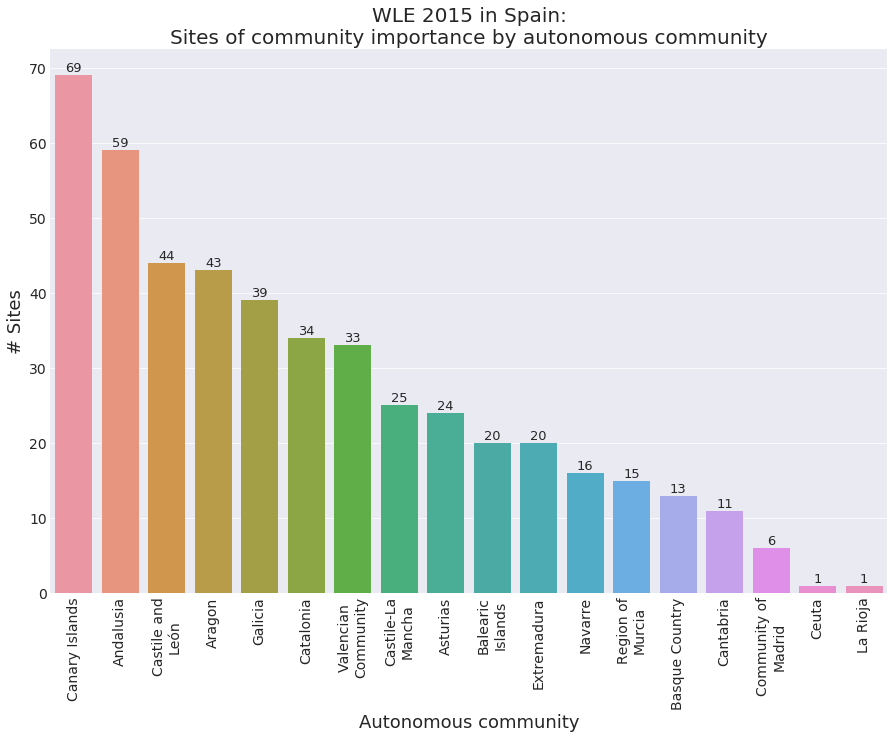

In [65]:
padding = {
    "2017": 0.3,
    "2016": 0.5,
    "2015": 0.5
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=sites_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous community", fontsize=18)
p.set_ylabel("# Sites", fontsize=18)

p.set_title(label='{1} {0} in {2}:\nSites of community importance by autonomous community'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + PADDING,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

desc = get_image_wikitext(image_wikitext,
                          'Sites of community importance by autonomous community in {1} {0} in {2}'.format(YEAR, TAG_EXT, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Sites of community importance by autonomous community.png".format(YEAR, TAG, COUNTRY), desc)

In [66]:
images_per_autcom = images_per_site_df.groupby(['aut_com']).\
                     sum().\
                     sort_values(by='count', ascending=False).\
                     reset_index()
images_per_autcom['aut_com'] = images_per_autcom['aut_com'].map(lambda x: wrap_label(x, 14))
images_per_autcom

,aut_com,count,latitude,longitude
0,Aragon,966,1806.215456,-14.379924
1,Andalusia,600,2187.452342,-274.458369
2,Canary Islands,458,1951.079780,-1123.097970
3,Castile and\nLeón,393,1837.373900,-209.795800
4,Galicia,376,1669.424500,-318.120600
5,Catalonia,324,1419.498159,62.618278
6,Castile-La\nMancha,259,994.499169,-72.654445
7,Valencian\nCommunity,241,1295.278191,-9.805789
8,Asturias,239,1038.660900,-138.496700
9,Region of\nMurcia,216,566.098933,-17.829122


[[commons:File:WLE 2015 in Spain - Photographs by autonomous community.png]]
Already in commons


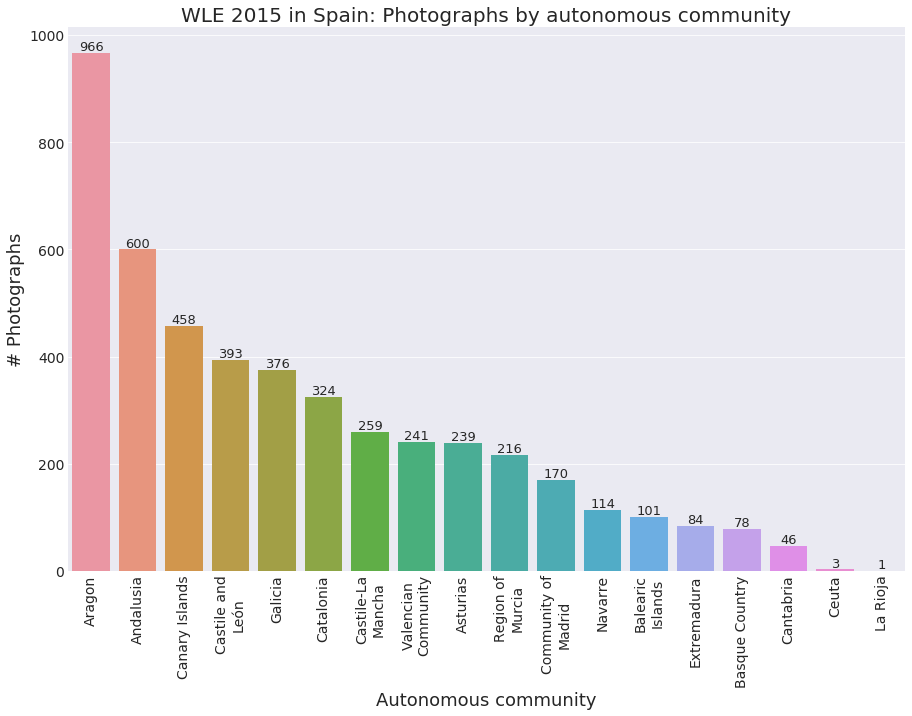

In [67]:
padding = {
    "2017": 4,
    "2016": 5,
    "2015": 5
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=images_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous community", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in {2}: Photographs by autonomous community'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + PADDING,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

desc = get_image_wikitext(image_wikitext,
                          'Photographs by autonomous community in {1} {0} in {2}'.format(YEAR, TAG_EXT, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Photographs by autonomous community.png".format(YEAR, TAG, COUNTRY), desc)

## Usage management

In [68]:
n=5
list_df = [images_df[i:i+n] for i in range(0, images_df.shape[0], n)]
usage_dict = {}

counter = 0
for df in list_df :
    query_string_items = list()
    for _, row in df.iterrows():
        title = 'File:{0}'.format(row["image_title"])
        query_string_items.append(title)
    raw_api_query_string = '|'.join(query_string_items)
    MW_API_QUERY_STRING["titles"] = raw_api_query_string
    
    r = requests.post(MW_API_BASE_URL, data=urlencode(MW_API_QUERY_STRING))
    response = r.text

    try:
        response_dict = json.loads(response)
        for _, value in response_dict["query"]["pages"].items():
            uses_dict = value['globalusage']
            tuples = [(item['wiki'], 1) for item in uses_dict if (item['ns'] in VALID_NAMESPACES)]
            summary = [reduce(lambda x, y: (x[0], x[1]+y[1]), group) for _, group in groupby(sorted(tuples), key=itemgetter(0))]
            if len(summary) > 0 :
                counter +=1
                title = value['title'].replace('File:', '')
                summary_dict = {tuple[0]: tuple[1] for tuple in summary}
                usage_dict.update({title: summary_dict})
    except Exception as e:
        print ('Error found ({})'.format(e))
        pass

In [69]:
# unique images used
usage_df = pd.DataFrame(usage_dict).transpose()
total_unique=usage_df.count(axis=1).count()
total_unique

790

In [70]:
# summary table
usages_df = pd.concat([usage_df.sum(), usage_df.count()], axis=1)
usages_df.columns = ['usages', 'unique']
usages_df['usages'] = usages_df['usages'].astype(int)
usages_df.sort_values(by=['unique'], axis=0, ascending=False, inplace=True)
usages_df['name'] = usages_df.index
usages_df['name'] = usages_df['name'].map(get_project_name)
usages_df.set_index(['name'], inplace=True)
usages_df = usages_df.iloc[np.lexsort([usages_df.index, -usages_df['unique']])]
usages_df

,usages,unique
name,,
Spanish Wikipedia,495,410
Catalan Wikipedia,175,148
Galician Wikipedia,144,116
Wikidata,110,103
Japanese Wikipedia,125,98
English Wikipedia,95,90
French Wikipedia,75,72
Basque Wikipedia,76,65
Dutch Wikipedia,38,37


In [71]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of projects with more than 1 picture
top_projects ={
    "2017": 15,
    "2016": 18,
    "2015": 23
}
TOP_PROJECTS = top_projects[str(YEAR)]

In [72]:
remaining_df = pd.DataFrame(usages_df.iloc[TOP_PROJECTS:].sum()).transpose()
other_projects_num = len(usages_df.index)-TOP_PROJECTS
remaining_df.index=['Other projects ({})'.format(other_projects_num)]
top_df = usages_df.iloc[:TOP_PROJECTS]
reduced_usages_df = top_df.append(remaining_df)
reduced_usages_df

,usages,unique
Spanish Wikipedia,495,410
Catalan Wikipedia,175,148
Galician Wikipedia,144,116
Wikidata,110,103
Japanese Wikipedia,125,98
English Wikipedia,95,90
French Wikipedia,75,72
Basque Wikipedia,76,65
Dutch Wikipedia,38,37
German Wikipedia,39,34


The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Unique photographs from Wiki Loves Earth 2015 in Spain used in WMF projects: top 23 projects}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-03-03
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2015 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE 2015 in Spain - Unique photographs used in WMF projects.png successful.

1 pages read
1 pages written
Script terminated successfully.


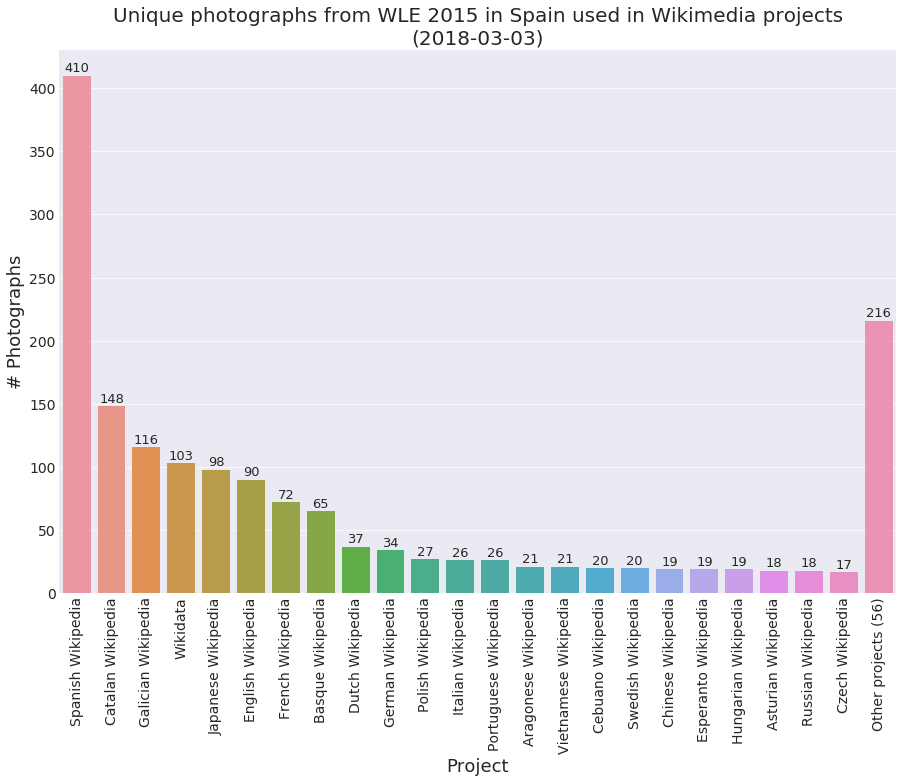

In [73]:
padding = {
    "2017": 0.5,
    "2016": 1,
    "2015": 3
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='unique', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='Unique photographs from {2} {0} in {3} used in Wikimedia projects\n({1})'.format(YEAR, now, TAG, COUNTRY), 
            fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + PADDING,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
desc = get_image_wikitext(image_wikitext,
                          'Unique photographs from {1} {0} in {2} used in WMF projects: top {3} projects'.format(YEAR, TAG_EXT, COUNTRY, TOP_PROJECTS),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Unique photographs used in WMF projects.png".format(YEAR, TAG, COUNTRY), desc)

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Uses of photographs from Wiki Loves Earth 2015 in Spain in WMF projects: top 23 projects}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-03-03
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2015 in Spain]]
Uploading file to commons:commons...
Sleeping for 5.2 seconds, 2018-03-03 00:12:16
Upload successful.
Upload of WLE 2015 in Spain - Uses of photographs in WMF projects.png successful.

1 pages read
1 pages written
Script terminated successfully.


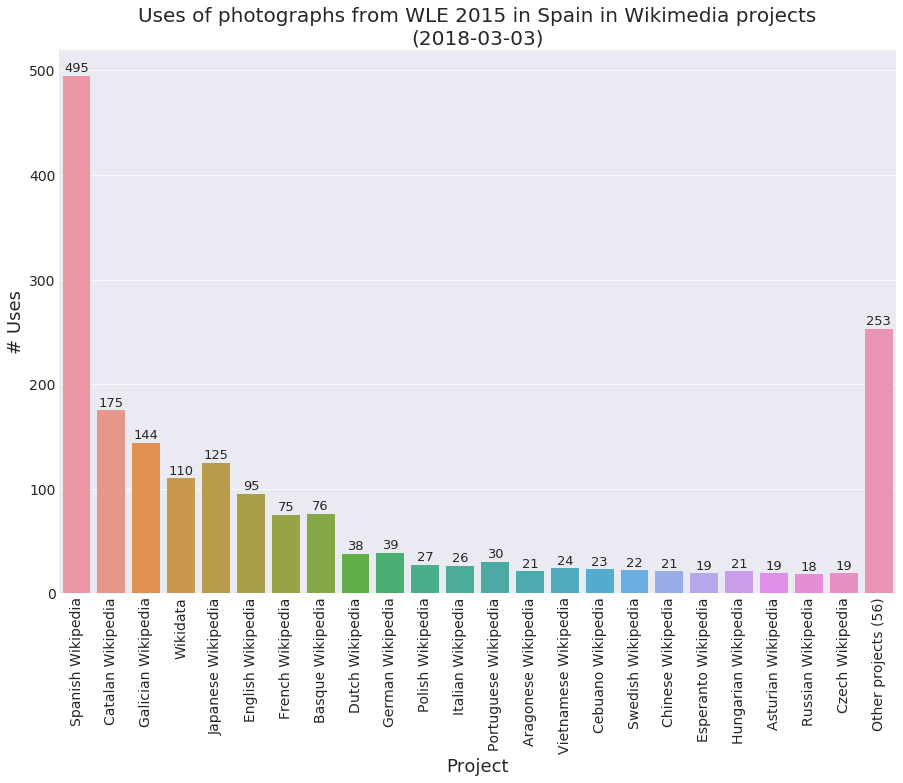

In [74]:
padding = {
    "2017": 0.6,
    "2016": 2,
    "2015": 4
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='usages', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Uses", fontsize=18)

p.set_title(label='Uses of photographs from {2} {0} in {3} in Wikimedia projects\n({1})'.format(YEAR, now, TAG, COUNTRY), 
            fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + PADDING,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
desc = get_image_wikitext(image_wikitext,
                          'Uses of photographs from {1} {0} in {2} in WMF projects: top {3} projects'.format(YEAR, TAG_EXT, COUNTRY, TOP_PROJECTS),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Uses of photographs in WMF projects.png".format(YEAR, TAG, COUNTRY), desc)

In [75]:
vf = np.vectorize(lambda x: wrap_label(x, 10))

projects = vf(reduced_usages_df.index.values)[::-1]
unique_uses = reduced_usages_df['unique'].values[::-1]
article_uses = reduced_usages_df['usages'].values[::-1]

In [76]:
padding = {
    "2015": {"left_offset": 116, "left_factor": 1.24, "right_offsest": 4} ,
    "2016": {"left_offset": 39, "left_factor": 1.2, "right_offsest": 3} ,
    "2017": {"left_offset": 15, "left_factor": 1.2, "right_offsest": 1} 
}

LEFT_PADDING = padding[str(YEAR)]["left_offset"]
LEFT_FACTOR = padding[str(YEAR)]["left_factor"]
RIGHT_PADDING = padding[str(YEAR)]["right_offsest"]

In [ ]:
y = np.arange(article_uses.size)
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=figsize_mid)
pylab.gcf().suptitle('Photographs from {2} {0} in Spain used in Wikimedia projects ({1})'.format(YEAR, now, TAG), 
                     fontsize=20, 
                     y=1.04)

axes[0].barh(y, unique_uses, align='center', color=sns.color_palette('hls', TOP_PROJECTS+1))
axes[0].set_title('# Unique photographs', fontsize=16)
axes[1].barh(y, article_uses, align='center', color=sns.color_palette('hls', TOP_PROJECTS+1))
axes[1].set_title('# Articles with photographs', fontsize=16)

axes[0].invert_xaxis()
axes[0].set_yticks(y)
axes[0].set_yticklabels(projects, horizontalalignment="center", fontsize=12)
axes[0].tick_params(axis='y', which='major', pad=44)
axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)
    
for patch in axes[1].patches:
    ax.text(patch.get_width() + RIGHT_PADDING,
            patch.get_y()+patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            va="center",
            fontsize=14)

for patch in axes[0].patches:
    ax.text(-(LEFT_PADDING + patch.get_width()*LEFT_FACTOR),
            patch.get_y()+patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            va="center",
            fontsize=14)

fig.tight_layout()
fig.subplots_adjust(wspace=0.18)

desc = get_image_wikitext(image_wikitext,
                          'Photographs from {1} {0} in {3} used in WMF projects: top {2} projects'.format(YEAR, TAG_EXT, TOP_PROJECTS, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(fig, "{1} {0} in {2} - Photographs used in WMF projects.png".format(YEAR, TAG, COUNTRY), desc)

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Photographs from Wiki Loves Earth 2015 in Spain used in WMF projects: top 23 projects}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-03-03
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2015 in Spain]]
Uploading file to commons:commons...
Sleeping for 3.8 seconds, 2018-03-03 00:12:27
Upload successful.
Upload of WLE 2015 in Spain - Photographs used in WMF projects.png successful.

1 pages read
1 pages written
Script terminated successfully.


## Quality Images

In [ ]:
# Quality images gallery
template = """This page lists the ${len(QI_list)} '''[[Commons:Quality Images|quality images]]''' uploaded as part of the 
[[Commons:${tag}|${tag}]] contest in ${year} in ${country}.

<gallery>
% for image in QI_list:
${image}
% endfor
</gallery>

'''Statistics generation date''': {{subst:CURRENTMONTHNAME}} {{subst:CURRENTDAY}}, {{subst:CURRENTYEAR}}

[[Category:${tag} in ${country}| Quality]]

"""
vars = {
    "QI_list": qi_list.values,
    "tag": TAG_EXT,
    "year": YEAR,
    "country": COUNTRY
}
t = Template(template)

In [ ]:
if qi_length > 0 :
    qi_gallery_text = t.render(**vars)
    qi_page = pb.Page(commons_site, GALLERY_QI)
    if qi_page.text != qi_gallery_text:
        qi_page.text = qi_gallery_text
        pb.output('Publishing --> {1} {0} in {2} featured articles gallery'.format(YEAR, TAG, COUNTRY))
        qi_page.save("{1} {0} in {2} featured articles gallery".format(YEAR, TAG, COUNTRY))

## Coverage

In [ ]:
es_site = pb.Site('es', 'wikipedia')
threshold_date = datetime(YEAR, 9, 1)

sites_df = pd.DataFrame(
    columns=['aut_com', 'commons_cat', 'image'])

for annex in annexes :
    page = pb.Page(es_site, annexes[annex][0])
    rev_id = None
    for i, revision in enumerate(page.revisions()) :
        if revision['timestamp'] < threshold_date:
            rev_id = i
            break
    for i, revision in enumerate(page.revisions(content=True)) :
        if i == rev_id :
            text = revision['text']
            break

    wikicode = mwh.parse(text)
    templates = [template for template in wikicode.filter_templates() if template.name.lower().strip() == "fila lic"]
    for template in templates :
        df_row = {
            "aut_com": annexes[annex][1],
            "commons_cat": None,
            "image": None
        }
        if annex == 'ES-CE' and '631' in template.get("código").value :
            df_row['aut_com'] = 'Ceuta'
        elif annex == 'ES-CE' :
            df_row['aut_com'] = 'Melilla'
        elif annex == 'ES-ML' :
            continue
        try:
            if template.get("categoría-Commons").value:
                if len(template.get("categoría-Commons").value.strip()) > 0 :
                    df_row["commons_cat"] = template.get("categoría-Commons").value.strip()
            if template.get("imagen").value:
                if len(template.get("imagen").value.strip()) > 0 :
                    df_row["image"] = template.get("imagen").value.strip()
        except Exception as e:
            print ('Exception ({0}) in {1} ({2})'.format(e, template.get("código").value.strip(), annexes[annex][1]))

        sites_df = sites_df.append(df_row, ignore_index=True)

In [ ]:
coverage_category = sites_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['commons_cat'].count()
coverage_images = sites_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['image'].count()

coverage_df = pd.concat([sites_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['aut_com'].count(),
                         sites_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['commons_cat'].count(),
                         sites_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['image'].count()], axis=1)
total_coverage = coverage_df.sum(numeric_only=True).rename('Total')
coverage_df = coverage_df.append(total_coverage)

coverage_df['aut_com'] = coverage_df['aut_com'].fillna(0).astype('int')
coverage_df['category_percentage'] = (100.*coverage_df['commons_cat']/coverage_df['aut_com']).round(2)
coverage_df['image_percentage'] = (100.*coverage_df['image']/coverage_df['aut_com']).round(2)
coverage_df['commons_cat'] = coverage_df['commons_cat'].fillna(0).astype('int')
coverage_df['image'] = coverage_df['image'].fillna(0).astype('int')
coverage_df['image_color'] = coverage_df['image_percentage'].apply(heat_color)
coverage_df['cat_color'] = coverage_df['category_percentage'].apply(heat_color)

In [ ]:
coverage_df

## Finalists

In [ ]:
cat_wle = pb.Category(commons_site, WLE_FINALIST_CATEGORY[str(YEAR)])
gen_wle = pagegenerators.CategorizedPageGenerator(cat_wle)

finalist_images_wle = [page.title(withNamespace=False) for page in gen_wle if page.is_filepage()]
finalist_images_count = len(finalist_images_wle)
finalist_images_count

In [ ]:
finalist_images_df = images_extended_df[images_extended_df['image_title'].isin(finalist_images_wle)]
finalist_authors = finalist_images_df['uploader'].value_counts()
finalist_authors = finalist_authors.iloc[np.lexsort([finalist_authors.index, -finalist_authors.values])]
finalist_authors

In [ ]:
finalist_authors_count = len(finalist_authors)
finalist_authors_count

In [ ]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of contestants with more than 1 finalist picture
top_finalists ={
    "2017": 25,
    "2016": 19,
    "2015": 21
}
TOP_FINALISTS = top_finalists[str(YEAR)]

In [ ]:
finalist_authors = finalist_authors.iloc[:TOP_FINALISTS]
finalist_authors

In [ ]:
padding = {
    "2017": 0.4,
    "2016": 0.2,
    "2015": 0.1
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize_mid)

p = sns.barplot(ax=ax, y=finalist_authors.index.map(flickr_ripper).map(lambda x: wrap_label(x, 18)), x=finalist_authors.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Contestants", fontsize=18)

p.set_title(label='{1} {0} in {2}: Top finalists'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + PADDING,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

desc = get_image_wikitext(image_wikitext,
                          'Top contributors reaching the final round of {1} {0} in {2}.'.format(YEAR, TAG_EXT, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Finalists.png".format(YEAR, TAG, COUNTRY), desc)

In [ ]:
finalist_sites = finalist_images_df['commons_cat'].value_counts()
finalist_sites = finalist_sites.iloc[np.lexsort([finalist_sites.index, -finalist_sites.values])]
finalist_sites

In [ ]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of sites with more than 1 picture
top_finalist_sites ={
    "2017": 24,
    "2016": 23,
    "2015": 22
}
TOP_FINALIST_SITES = top_finalist_sites[str(YEAR)]

In [ ]:
finalist_sites = finalist_sites.iloc[:TOP_FINALIST_SITES]
finalist_sites

In [ ]:
padding = {
    "2017": 0.1,
    "2016": 0.1,
    "2015": 0.1
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize_mid)

p = sns.barplot(ax=ax, y=finalist_sites.index.map(lambda x: wrap_label(x.replace(' (site of community importance)', ''), 30)), x=finalist_sites.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Sites of community importance", fontsize=18)

p.set_title(label='{1} {0} in {2}: Sites of community importance in the final round'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + PADDING,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

desc = get_image_wikitext(image_wikitext,
                          'Top sites of community importance in the final round of {1} {0} in {2}.'.format(YEAR, TAG_EXT, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in Spain - Finalist sites of community importance.png".format(YEAR, TAG), desc)

In [ ]:
finalist_autcoms = finalist_images_df['aut_com'].value_counts()
finalist_autcoms = finalist_autcoms.iloc[np.lexsort([finalist_autcoms.index, -finalist_autcoms.values])]
finalist_autcoms

In [ ]:
padding = {
    "2017": 0.3,
    "2016": 0.4,
    "2015": 0.2
}
PADDING = padding[str(YEAR)]

fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=finalist_autcoms.index.map(lambda x: wrap_label(x, 14)), x=finalist_autcoms.values.astype(int))
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Autonomous communities", fontsize=18)

p.set_title(label='{1} {0} in {2}: Autonomous communities in the final round'.format(YEAR, TAG, COUNTRY), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + PADDING,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

desc = get_image_wikitext(image_wikitext,
                          'Spanish autonomous communities in the final round of {1} {0} in {2}.'.format(YEAR, TAG_EXT, COUNTRY),
                          YEAR, TAG_EXT, COUNTRY
                         )
upload_to_commons2(p, "{1} {0} in {2} - Finalist autonomous communities.png".format(YEAR, TAG, COUNTRY), desc)

## Page generation

In [ ]:
template_file = os.path.join(templates_directory, 'wle.wiki')
fh = open(template_file, 'r', encoding = "utf-8")
template = fh.read()
fh.close()

In [ ]:
vars = {
    "images_length": total_images_length,
    "valid_images_length": valid_images_length,
    "site_images_length": 0,
    "qi_length": qi_length,
    "gallery_quality_images": GALLERY_QI,
    "wle_sites_length": wle_sites_length,
    "authors_length": authors_length,
    "top_authors": TOP_UPLOADERS,
    "top_authors_by_site": TOP_UPLOADERS_BY_SITE,
    "new_uploaders_length": new_uploaders_length,
    "site_length": site_length,
    "top_sites": TOP_SITES,
    "aut_coms": aut_coms,
    "authors_df": authors_df,
    "images_per_site_df": images_per_site_df,
    "usages_df": usages_df,
    "coverage_df": coverage_df,
    "total_unique": total_unique,
    "new_uploaders": new_uploaders_contributions,
    "new_uploaders_sum": new_uploaders_contributions.sum(),
    "top_projects": TOP_PROJECTS,
    "finalist_images_count": finalist_images_count,
    "finalist_authors_count": finalist_authors_count,
    "finalist_cat": WLE_FINALIST_CATEGORY[str(YEAR)],
    "year": YEAR,
    "tag": TAG,
    "full_tag": TAG_EXT,
    "base": BASE_NAME,
    "country": COUNTRY,
    "date": datetime.now().strftime("%B %-d, %Y")
}
t = Template(template)
statisticts_text = t.render(**vars)

In [ ]:
stats_page = pb.Page(commons_site, STATISTICS_PAGE)
if stats_page.text.strip() != statisticts_text.strip() :
    stats_page.text = statisticts_text
    pb.output('Publishing --> {1} {0} in {2} Statistics'.format(YEAR, TAG, COUNTRY))
    stats_page.save("{1} {0} in {2} statistics".format(YEAR, TAG, COUNTRY))